In [2]:
import tensorflow as tf
from models import decoder, encoder, vae
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
from scipy.stats import norm
from hyperparameters import *
from sklearn.model_selection import train_test_split

In [3]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "../data",
    # validation_split=0.2,
    # subset="training",
    seed=123,
    batch_size=16,
    image_size=(64 + 32, 32 + 32),
)

Found 2106 files belonging to 1 classes.


2024-05-07 06:25:14.308182: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-05-07 06:25:14.308227: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-05-07 06:25:14.308234: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-05-07 06:25:14.308253: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-07 06:25:14.308265: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
img_processor = tf.keras.layers.CenterCrop(64, 32)

In [40]:
data = []
for images, labels in train_dataset.unbatch():
    data.append(images)
data = np.array(data) / 255

2024-05-07 06:34:08.147736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [63]:
x_train_org, x_val_org = train_test_split(data, test_size=0.2, random_state=42)
x_train, x_val = img_processor(x_train_org).numpy(), img_processor(x_val_org).numpy()

In [64]:
encoder_model = encoder.build_encoder(**ENCODER_MODEL_HYPERPARAMETERS)
decoder_model = decoder.build_decoder(**DECODER_MODEL_HYPERPARAMETERS)

vae_model = vae.VAE(encoder_model, decoder_model, reconstruction_loss_weight=50, kl_loss_weight=1)
vae_model.compile(optimizer="adam")

In [65]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_reconstruction_loss", patience=5, restore_best_weights=True, mode="min"
)

In [66]:
history_vae_training = vae_model.fit(x_train, epochs=200, batch_size=256, validation_data=x_val, callbacks=[early_stopping])

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - kl_loss: 54.1543 - loss: 70547.3359 - reconstruction_loss: 1409.8636 - val_kl_loss: 505.4632 - val_loss: 69679.8984 - val_reconstruction_loss: 1383.4888
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - kl_loss: 701.5175 - loss: 68387.8438 - reconstruction_loss: 1353.7266 - val_kl_loss: 148.1711 - val_loss: 67589.3125 - val_reconstruction_loss: 1348.8228
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - kl_loss: 131.5522 - loss: 65203.0820 - reconstruction_loss: 1301.4305 - val_kl_loss: 52.1245 - val_loss: 64788.2461 - val_reconstruction_loss: 1294.7224
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - kl_loss: 55.6035 - loss: 61170.3906 - reconstruction_loss: 1222.2957 - val_kl_loss: 32.9382 - val_loss: 60809.3789 - val_reconstruction_loss: 1215.5288
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - kl_loss: 38.5468 - loss: 59064.8984 - reconstruction_loss: 1180.5271 - val_kl_loss: 20.3745 - val_loss: 60788.3320 - val_recons

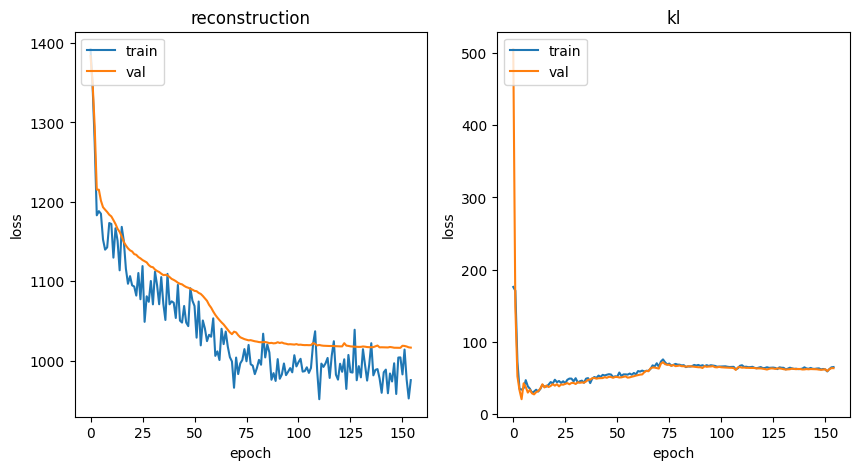

In [67]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(history_vae_training.history["reconstruction_loss"])
plt.plot(history_vae_training.history["val_reconstruction_loss"])
plt.title("reconstruction")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")

plt.subplot(122)
plt.plot(history_vae_training.history["kl_loss"])
plt.plot(history_vae_training.history["val_kl_loss"])
plt.title("kl")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")

plt.show()

In [68]:
_, _, z = encoder_model.predict(x_val)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [69]:
from scipy.cluster.hierarchy import dendrogram
from sklearn import cluster

def plot_dendrogram(mm, **kwargs):
    counts = np.zeros(mm.children_.shape[0])
    n_samples = len(mm.labels_)
    for i, merge in enumerate(mm.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [mm.children_, mm.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

In [72]:
ac = cluster.AgglomerativeClustering(n_clusters=3)

classes = ac.fit_predict(z)

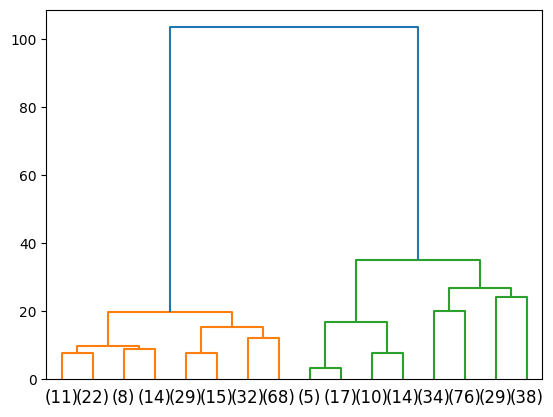

In [82]:
ac2 = cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None)
ac2.fit(z)
plot_dendrogram(ac2, truncate_mode="level", p=3)

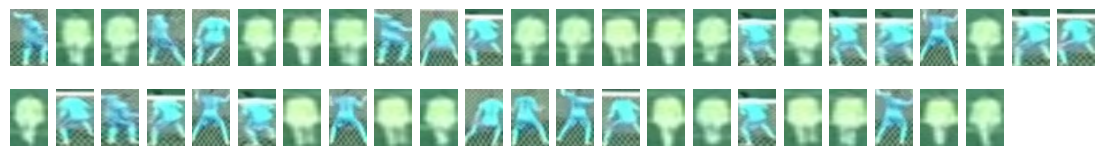

In [75]:
j = 0

plt.figure(figsize=(14, 5))
for i in range(len(classes)):
    if classes[i] == 2:
        plt.subplot(5, 24, j + 1)
        plt.imshow(x_val_org[i])
        plt.axis("off")
        j += 1
    if j == 60:
        break
        
plt.show()

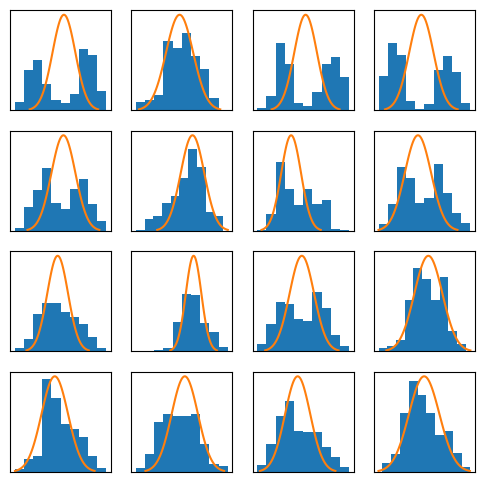

In [55]:
plot_size = int(np.sqrt(LATENT_DIM))

x_vector = np.linspace(-3, 3, 100)
norm_distribution = norm.pdf(x_vector, 0, 1)

plt.figure(figsize=(6, 6))
for i in range(LATENT_DIM):
    plt.subplot(plot_size, plot_size, i + 1)
    plt.hist(z[:, i], density=True)
    plt.plot(x_vector, norm_distribution)
    plt.xticks([])
    plt.yticks([])
plt.show()